In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import heapq
from tqdm import tqdm
import tensorflow as tf
from joblib import Parallel, delayed, cpu_count

import re
import os
import heapq

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alx-movie-recommendation-project-2024/sample_submission.csv
/kaggle/input/alx-movie-recommendation-project-2024/movies.csv
/kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv
/kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv
/kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv
/kaggle/input/alx-movie-recommendation-project-2024/train.csv
/kaggle/input/alx-movie-recommendation-project-2024/test.csv
/kaggle/input/alx-movie-recommendation-project-2024/tags.csv
/kaggle/input/alx-movie-recommendation-project-2024/links.csv


In [6]:
# Loading the data
train_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/train.csv')
test_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/test.csv')
sample_submission_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/sample_submission.csv')


movies_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/movies.csv')
links_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/links.csv')
tags_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/tags.csv')
genome_scores_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv')
genome_tags_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv')
imdb_data_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv')

# Displaying the first few rows of each DataFrame
train_df.head(), test_df.head(), sample_submission_df.head(), movies_df.head(), links_df.head(), tags_df.head(), genome_scores_df.head(), genome_tags_df.head()



(   userId  movieId  rating   timestamp
 0    5163    57669     4.0  1518349992
 1  106343        5     4.5  1206238739
 2  146790     5459     5.0  1076215539
 3  106362    32296     2.0  1423042565
 4    9041      366     3.0   833375837,
    userId  movieId
 0       1     2011
 1       1     4144
 2       1     5767
 3       1     6711
 4       1     7318,
        Id  rating
 0  1_2011     1.0
 1  1_4144     1.0
 2  1_5767     1.0
 3  1_6711     1.0
 4  1_7318     1.0,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3             

In [7]:
# Let's start by looking at the shape of our datasets
print(f"Train DataFrame shape: {train_df.shape}")
print(f"Test DataFrame shape: {test_df.shape}")
print(f"Sample Submission DataFrame shape: {sample_submission_df.shape}")

# Display basic statistics for the train dataset
train_df.describe()

Train DataFrame shape: (10000038, 4)
Test DataFrame shape: (5000019, 2)
Sample Submission DataFrame shape: (5000019, 2)


,userId,movieId,rating,timestamp
count,1.000004e+07,1.000004e+07,1.000004e+07,1.000004e+07
mean,8.119909e+04,2.138911e+04,3.533395e+00,1.215677e+09
std,4.679359e+04,3.919578e+04,1.061124e+00,2.268921e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.197000e+03,3.000000e+00,1.011742e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.199019e+09
75%,1.215790e+05,8.630000e+03,4.000000e+00,1.447242e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


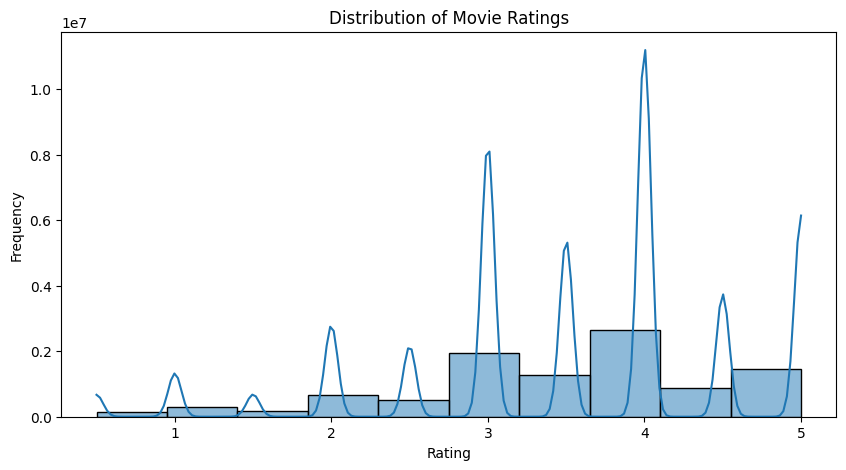

In [4]:
# Plot the distribution of ratings
plt.figure(figsize=(10, 5))
sns.histplot(train_df['rating'], bins=10, kde=True)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


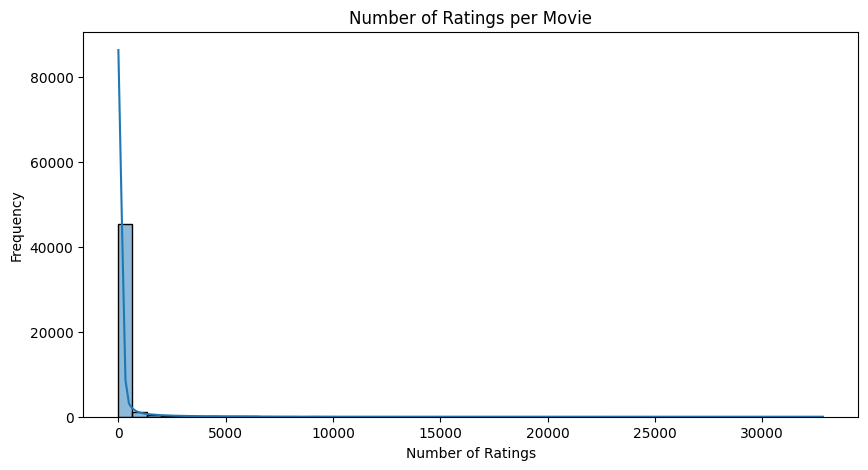

In [5]:
# Plot the number of ratings per movie
ratings_per_movie = train_df.groupby('movieId').size()
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_movie, bins=50, kde=True)
plt.title("Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


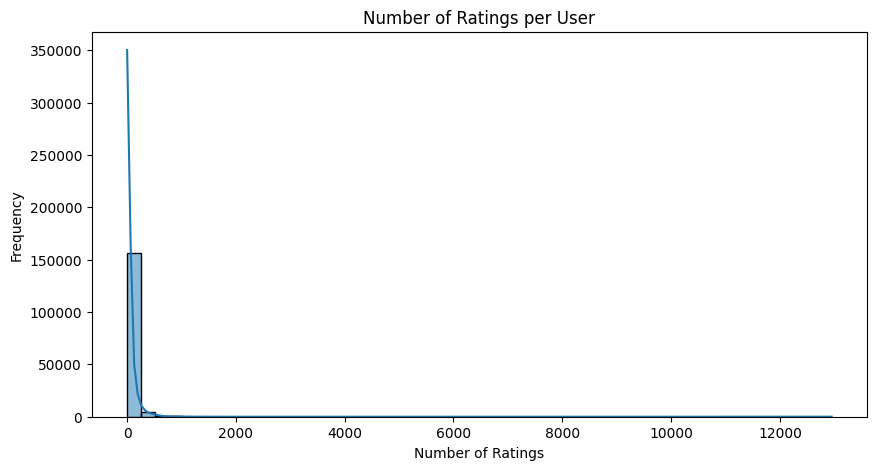

In [6]:
# Plot the number of ratings per user
ratings_per_user = train_df.groupby('userId').size()
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_user, bins=50, kde=True)
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


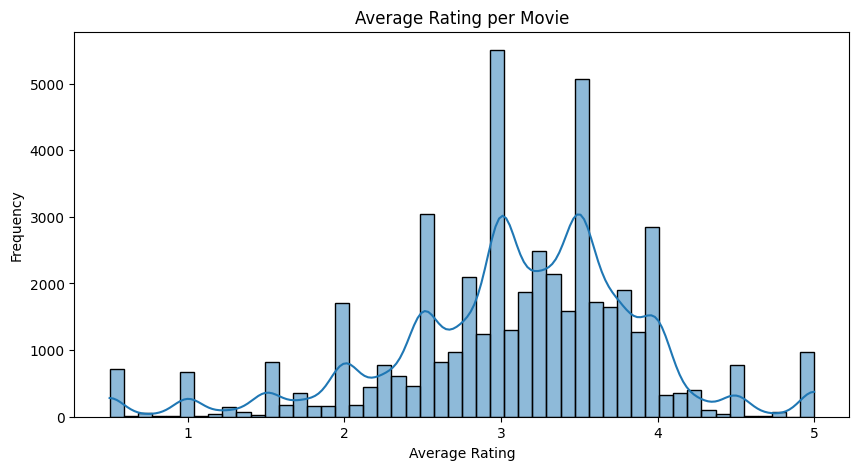

In [7]:
# Plot the average rating per movie
avg_rating_per_movie = train_df.groupby('movieId')['rating'].mean()
plt.figure(figsize=(10, 5))
sns.histplot(avg_rating_per_movie, bins=50, kde=True)
plt.title("Average Rating per Movie")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()


 Data Cleaning and Preprocessing


In [8]:
# Checking for missing values
print("Missing values in train_df:")
print(train_df.isnull().sum())

print("Missing values in test_df:")
print(test_df.isnull().sum())

print("Missing values in sample_submission_df:")
print(sample_submission_df.isnull().sum())

print("Missing values in movies_df:")
print(movies_df.isnull().sum())

print("Missing values in links_df:")
print(links_df.isnull().sum())

print("Missing values in tags_df:")
print(tags_df.isnull().sum())

print("Missing values in genome_scores_df:")
print(genome_scores_df.isnull().sum())

print("Missing values in genome_tags_df:")
print(genome_tags_df.isnull().sum())

print("Missing values in imdb_data_df:")
print(imdb_data_df.isnull().sum())


Missing values in train_df:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Missing values in test_df:
userId     0
movieId    0
dtype: int64
Missing values in sample_submission_df:
Id        0
rating    0
dtype: int64
Missing values in movies_df:
movieId    0
title      0
genres     0
dtype: int64
Missing values in links_df:
movieId      0
imdbId       0
tmdbId     107
dtype: int64
Missing values in tags_df:
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
Missing values in genome_scores_df:
movieId      0
tagId        0
relevance    0
dtype: int64
Missing values in genome_tags_df:
tagId    0
tag      0
dtype: int64
Missing values in imdb_data_df:
movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64


In [9]:
# Clean text data by removing punctuation and extra spaces
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', str(text))
    text = re.sub('\s+', ' ', text)
    return text.strip()

# Clean relevant columns
movies_df['title'] = movies_df['title'].apply(clean_text)
movies_df['genres'] = movies_df['genres'].apply(clean_text)
imdb_data_df['title_cast'] = imdb_data_df['title_cast'].apply(clean_text)
imdb_data_df['director'] = imdb_data_df['director'].apply(clean_text)
imdb_data_df['plot_keywords'] = imdb_data_df['plot_keywords'].apply(clean_text)
tags_df['tag'] = tags_df['tag'].apply(clean_text)
genome_tags_df['tag'] = genome_tags_df['tag'].apply(clean_text)

# Aggregate tags and genome tags into descriptions
tags_agg = tags_df.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
genome_tags_agg = genome_scores_df.merge(genome_tags_df, on='tagId')
genome_tags_agg = genome_tags_agg.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()



In [10]:
movies_df.value_counts().unique

<bound method Series.unique of movieId  title                                                      genres                                 
209171   Women of Devils Island 1962                                ActionAdventureDrama                       1
1        Toy Story 1995                                             AdventureAnimationChildrenComedyFantasy    1
2        Jumanji 1995                                               AdventureChildrenFantasy                   1
3        Grumpier Old Men 1995                                      ComedyRomance                              1
4        Waiting to Exhale 1995                                     ComedyDramaRomance                         1
                                                                                                              ..
27       Now and Then 1995                                          ChildrenDrama                              1
28       Persuasion 1995                                            Dr

In [11]:
genome_tags_agg.shape

(13816, 2)

In [12]:
# Initialize an empty list to store movie descriptions
movie_descriptions_list = []

# Iterate through movies_df to append relevant information
for index, row in tqdm(movies_df.iterrows(), total=movies_df.shape[0]):
    movieId = row['movieId']
    
    # Get relevant information
    title = row['title']
    genres = row['genres']
    
    # Find the corresponding row in imdb_data_df
    imdb_row = imdb_data_df[imdb_data_df['movieId'] == links_df[links_df['movieId'] == movieId]['imdbId'].values[0]]
    
    title_cast = imdb_row['title_cast'].values[0] if not imdb_row.empty else ''
    director = imdb_row['director'].values[0] if not imdb_row.empty else ''
    plot_keywords = imdb_row['plot_keywords'].values[0] if not imdb_row.empty else ''
    
    # Find the corresponding tags and genome tags
    tag_row = tags_agg[tags_agg['movieId'] == movieId]
    genome_tag_row = genome_tags_agg[genome_tags_agg['movieId'] == movieId]
    
    tags = tag_row['tag'].values[0] if not tag_row.empty else ''
    genome_tags = genome_tag_row['tag'].values[0] if not genome_tag_row.empty else ''
    
    # Combine into a movie description
    movie_description = f"{title} {genres} {title_cast} {director} {plot_keywords} {tags} {genome_tags}"
    
    # Append to movie_descriptions_list
    movie_descriptions_list.append({
        'movieId': movieId,
        'movie_description': movie_description
    })

# Convert the list to a DataFrame
movie_descriptions = pd.DataFrame(movie_descriptions_list)

# Fill NaN values in movie_description
movie_descriptions['movie_description'].fillna('', inplace=True)

# Display the first few rows of the movie descriptions
movie_descriptions.head()


100%|██████████| 62423/62423 [01:26<00:00, 725.64it/s]
/tmp/ipykernel_13/2409044842.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movie_descriptions['movie_description'].fillna('', inplace=True)


,movieId,movie_description
0,1,Toy Story 1995 AdventureAnimationChildrenComed...
1,2,Jumanji 1995 AdventureChildrenFantasy Oscar Di...
2,3,Grumpier Old Men 1995 ComedyRomance funny b...
3,4,Waiting to Exhale 1995 ComedyDramaRomance b...
4,5,Father of the Bride Part II 1995 Comedy Michel...


In [13]:
movie_descriptions.shape

(62423, 2)

In [14]:
# Shuffle the movie_descriptions DataFrame
movie_descriptions = movie_descriptions.sample(frac=1, random_state=42).reset_index(drop=True)

# Partition the DataFrame into 4 groups
partitions = np.array_split(movie_descriptions, 4)


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [16]:
import tensorflow as tff

tfidf_vectorizers = []
tfidf_matrices = []
cosine_sim_matrices = []

for i, partition in enumerate(partitions):
    # Initialize TfidfVectorizer for each partition
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.0, stop_words='english')
    
    # Fit and transform the movie descriptions
    tfidf_matrix = tf.fit_transform(partition['movie_description'])
    
    # Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Convert cosine similarity matrix to TensorFlow tensor
    cosine_sim_matrix_tensor = tff.constant(cosine_sim_matrix)

    # Assign to global variables
    globals()[f'tfidf_{i+1}_matrix'] = tfidf_matrix
    globals()[f'cosine_sim_{i+1}_matrix'] = cosine_sim_matrix_tensor
    
    tfidf_vectorizers.append(tf)
    tfidf_matrices.append(tfidf_matrix)
    cosine_sim_matrices.append(cosine_sim_matrix_tensor)


I0000 00:00:1718959376.392730      13 service.cc:145] XLA service 0x5cee71d33280 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718959376.392784      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1718959376.392788      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1718959376.392791      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1718959376.392795      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1718959376.392798      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1718959376.392801      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1718959376.392803      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1718959376.392806      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


In [17]:
# Update indices and titles for partitions
partition_indices = [pd.Series(partition.index, index=partition['movieId']) for partition in partitions]

def content_generate_rating_estimate(movie_id, user, rating_data, k=20, threshold=0.0):
    partition_idx = -1
    b_idx = -1

    # Find the partition for the movie_id
    for i, indices in enumerate(partition_indices):
        if movie_id in indices.index:
            partition_idx = i + 1
            b_idx = indices[movie_id]
            break

    # If the movie_id is not found in any partition, return the average rating
    if partition_idx == -1:
        print(f"Movie ID {movie_id} not found in any partition.")
        return rating_data['rating'].mean()

    neighbors = []

    # Iterate through user ratings
    for index, row in rating_data[rating_data['userId'] == user].iterrows():
        try:
            # Find the similarity index
            sim_idx = partition_indices[partition_idx - 1][row['movieId']]
            if b_idx < cosine_sim_matrices[partition_idx - 1].shape[0] and sim_idx < cosine_sim_matrices[partition_idx - 1].shape[1]:
                sim = cosine_sim_matrices[partition_idx - 1][b_idx, sim_idx].numpy()
                neighbors.append((sim, row['rating']))
        except (KeyError, IndexError):
            continue

    # Get the top-k neighbors
    k_neighbors = heapq.nlargest(k, neighbors, key=lambda t: t[0])
    simTotal, weightedSum = 0, 0

    # Calculate the predicted rating
    for (simScore, rating) in k_neighbors:
        if simScore > threshold:
            simTotal += simScore
            weightedSum += simScore * rating

    try:
        predictedRating = weightedSum / simTotal
    except ZeroDivisionError:
        # Fallback to average rating for the movie if no neighbors found
        predictedRating = np.mean(rating_data[rating_data['movieId'] == movie_id]['rating'])

    return predictedRating


In [ ]:
# Extract userId and movieId from sample_submission_df
sample_submission_df['userId'] = sample_submission_df['Id'].str.split('_').str[0].astype(int)
sample_submission_df['movieId'] = sample_submission_df['Id'].str.split('_').str[1].astype(int)

# Function to compute the rating for a single row
def compute_rating(row, train_df):
    return content_generate_rating_estimate(row['movieId'], row['userId'], train_df)

# Function to process a chunk and return the computed ratings
def process_chunk(chunk_df, train_df):
    chunk_df['rating'] = chunk_df.apply(lambda row: compute_rating(row, train_df), axis=1)
    return chunk_df[['Id', 'rating']]

# Define the chunk size
chunk_size = 10000  # Adjust chunk size based on memory limits and performance

# Path to the submission file
submission_file_path = 'submission_2.csv'

# Check if the submission file already exists and create if necessary
if not os.path.exists(submission_file_path):
    with open(submission_file_path, 'w') as f:
        f.write('Id,rating\n')

# Split the sample_submission_df into chunks
chunks = [sample_submission_df.iloc[i:i + chunk_size] for i in range(0, sample_submission_df.shape[0], chunk_size)]

# Process the chunks in parallel and write the results incrementally
num_chunks = len(chunks)
num_cores = min(4, cpu_count())  # Adjust number of cores as needed

for i, chunk in enumerate(tqdm(chunks, desc="Processing chunks")):
    print(f"Processing chunk {i+1}/{num_chunks}")
    
    # Compute ratings for the current chunk
    chunk_ratings = Parallel(n_jobs=num_cores)(delayed(process_chunk)(chunk, train_df) for chunk in [chunk])
    
    # Flatten the list of dataframes into a single dataframe
    result_chunk = pd.concat(chunk_ratings, axis=0)
    
    # Append the current chunk to the CSV file
    result_chunk.to_csv(submission_file_path, mode='a', header=False, index=False)

print("Finished writing to CSV file.")
